In [ ]:
 import torch
 import torch.nn as nn
 import torch.optim as optim
 from torch.utils.data import DataLoader, Subset
 from torchvision.transforms import Compose, Resize, ToTensor
 from torchvision.datasets import ImageFolder
 import matplotlib.pyplot as plt
 import numpy as np
 import cv2
 from torch.cuda.amp import GradScaler, autocast
 import kagglehub

In [ ]:
 # Download the dataset using kagglehub
 path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
 print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2


In [ ]:
 # Load the dataset (replace with your dataset folder structure)
 # Assuming the dataset contains images and labels in subdirectories.
 dataset = ImageFolder(root=path, transform=Compose([Resize((128, 128)), ToTensor()]))
 # Use a subset for faster execution (you can use the full dataset for real training)
 train_data = Subset(dataset, range(100))  # 100 samples for training
 test_data = Subset(dataset, range(20))    # 20 samples for testing
 train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
 test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

In [ ]:
 # U-Net model definition (Small version for simplicity)
 class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    def forward(self, x):
        enc = self.encoder(x)
        middle = self.middle(enc)
        dec = self.decoder(middle)
        return dec

In [ ]:
 # Initialize the model
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 model = SmallUNet().to(device)
  # Criterion and optimizer
 criterion = nn.BCELoss()
 optimizer = optim.Adam(model.parameters(), lr=1e-4)
 scaler = GradScaler()  # Enable mixed precision training

<ipython-input-84-5f32e2c427e3>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enable mixed precision training


In [ ]:
 # Training loop (simplified for 1 epoch)
 epochs = 3
 for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        masks = torch.rand_like(images[:, :1, :, :]).to(device)  # Placeholder masks
        optimizer.zero_grad()
        with autocast():  # Mixed precision
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

<ipython-input-85-f7367837e2d7>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Epoch 1/3, Loss: 0.7209
Epoch 2/3, Loss: 0.7167
Epoch 3/3, Loss: 0.7101


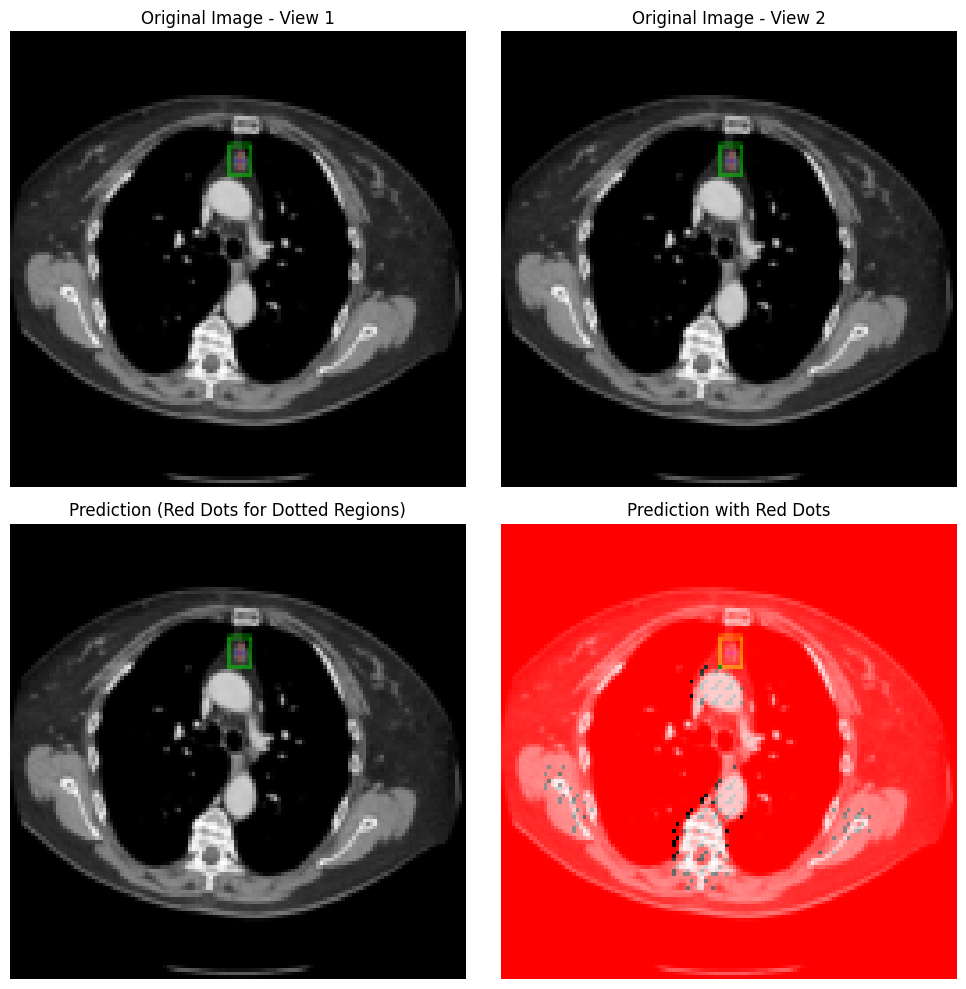

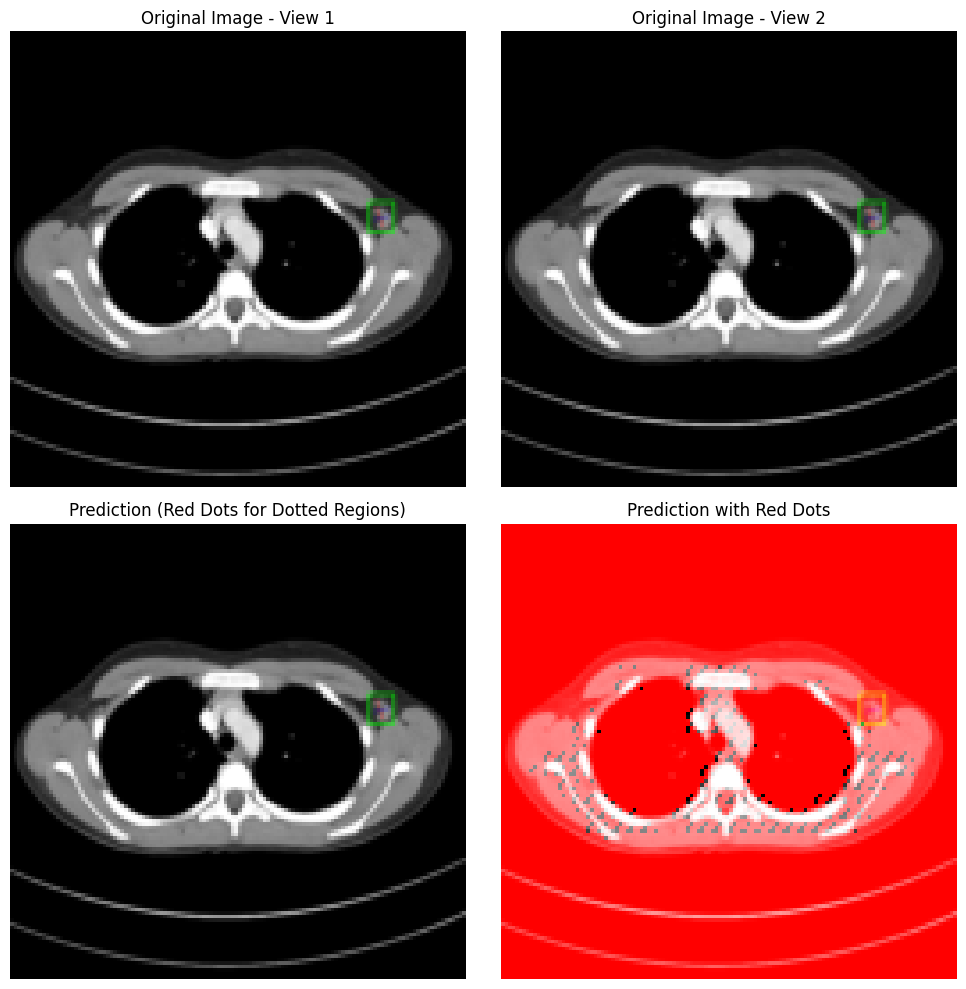

In [ ]:
 # Model evaluation (spotting dotted regions and marking them with red dots)
 model.eval()
 with torch.no_grad():
    images, _ = next(iter(test_loader))  # Take a batch from the test set
    images = images.to(device)
    outputs = model(images).cpu()  # Get predictions
    images = images.cpu()
    for i in range(len(images)):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        axs = axs.ravel()
        # Original image
        image = images[i].permute(1, 2, 0).numpy()  # Convert to numpy
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title("Original Image - View 1")
        axs[0].axis("off")
        axs[1].imshow(image, cmap='gray')
        axs[1].set_title("Original Image - View 2")
        axs[1].axis("off")
        # Prediction
        prediction = outputs[i, 0].numpy()  # Single-channel prediction
        prediction = (prediction > 0.5).astype(float)  # Binary mask (threshold at 0.5)
        # Create overlay for prediction with red dots
        overlay = image.copy()
        prediction_coords = np.where(prediction == 1)  # Find coordinates of "dotted" regions (predicted areas)

        for y, x in zip(*prediction_coords):  # Mark red dots
            overlay[y, x, 0] = 255  # Red channel
        # Show prediction with red dots on top of the original image
        axs[2].imshow(image, cmap='gray')
        axs[2].set_title("Prediction (Red Dots for Dotted Regions)")
        axs[2].axis("off")
        axs[3].imshow(overlay, cmap='gray')
        axs[3].set_title("Prediction with Red Dots")
        axs[3].axis("off")
        plt.tight_layout()
        plt.show()